# AneRBC Dataset Visualization

Explores and visualizes both **AneRBC-I** and **AneRBC-II** datasets:
- Side-by-side anemic vs healthy sample images with CBC reports
- Per-dataset image counts and resolutions
- AneRBC-I vs AneRBC-II comparison
- Illustration of how AneRBC-I images are divided into 12 sub-images in AneRBC-II

In [67]:
# --- Imports ---
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image
from pathlib import Path
from collections import defaultdict
import pandas as pd
import numpy as np
from IPython.display import display, HTML

In [68]:
# --- Path Setup ---
def find_repo_root(start=Path.cwd(), marker='AneRBC_dataset'):
    p = start.resolve()
    while True:
        if (p / marker).exists():
            return p
        if p.parent == p:
            return start.resolve()
        p = p.parent

repo_root = find_repo_root()
base_i  = repo_root / 'AneRBC_dataset' / 'AneRBC-I'
base_ii = repo_root / 'AneRBC_dataset' / 'AneRBC-II'

print(f"Repo root : {repo_root}")
print(f"AneRBC-I  : {base_i}")
print(f"AneRBC-II : {base_ii}")

Repo root : /Users/kiran/Downloads/fyp
AneRBC-I  : /Users/kiran/Downloads/fyp/AneRBC_dataset/AneRBC-I
AneRBC-II : /Users/kiran/Downloads/fyp/AneRBC_dataset/AneRBC-II


In [69]:
# --- Helper Functions ---

def parse_cbc_text(txt):
    """Parse CBC report text into (test, value, ref, abnormal) tuples."""
    items = []
    for line in [l.strip() for l in txt.splitlines() if l.strip()]:
        parts = [p.strip() for p in line.split(',')]
        test  = parts[0]
        value = parts[1] if len(parts) >= 2 else ''
        ref   = parts[2] if len(parts) >= 3 else ''
        abnormal = '*' in line or value.startswith('*')
        items.append((test, value.replace('*', '').strip(), ref, abnormal))
    return items


def cbc_html_table(items):
    """Render CBC items as a colour-coded HTML table."""
    rows = []
    for test, value, ref, abnormal in items:
        bg = '#ffe6e6' if abnormal else '#e9ffe9'
        rows.append(
            f"<tr style='background:{bg};border-bottom:1px solid #ddd'>"
            f"<td style='padding:6px;min-width:160px'><b>{test}</b></td>"
            f"<td style='padding:6px'>{value}</td>"
            f"<td style='padding:6px;color:#666'>{ref}</td></tr>"
        )
    return '<table style="border-collapse:collapse;width:100%;font-family:Arial,sans-serif">' + ''.join(rows) + '</table>'


def get_img_size(img_list):
    """Return (width, height) of the first openable image in img_list."""
    for p in img_list:
        try:
            with Image.open(p) as im:
                return im.size
        except Exception:
            continue
    return None


def extract_pid(stem):
    """Extract a normalised patient ID from a file stem.
    Strips leading zeros so '0001' and '001' both map to '1',
    allowing AneRBC-I CBC filenames (001_a) to match AneRBC-II image filenames (0001_01_a).
    """
    raw = stem.split('_')[0]
    try:
        return str(int(raw))   # '0001' → '1', '001' → '1'
    except ValueError:
        return raw


def show_pair(an_img, an_cbc, an_label, h_img, h_cbc, h_label):
    """Display one anemic and one healthy image side-by-side with their CBC tables."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    for ax, img_path, label in zip(axes, [an_img, h_img], [an_label, h_label]):
        color = '#b30000' if label.lower().startswith('an') else '#007a00'
        if img_path.exists():
            ax.imshow(Image.open(img_path).convert('RGB'))
        else:
            ax.text(0.5, 0.5, 'Image not found', ha='center', va='center')
        ax.axis('off')
        ax.set_title(label, fontsize=16, color=color, pad=12)
    plt.tight_layout()
    plt.show()

    an_items = parse_cbc_text(an_cbc.read_text()) if an_cbc.exists() else []
    h_items  = parse_cbc_text(h_cbc.read_text())  if h_cbc.exists()  else []
    display(HTML(
        '<div style="display:flex;gap:20px;align-items:flex-start">'
        f'<div style="flex:1;padding:8px;border-radius:6px;background:#fff7f7">'
        f'<h3 style="color:#8b0000">Anemic CBC</h3>{cbc_html_table(an_items)}</div>'
        f'<div style="flex:1;padding:8px;border-radius:6px;background:#f7fff7">'
        f'<h3 style="color:#006400">Healthy CBC</h3>{cbc_html_table(h_items)}</div>'
        '</div>'
    ))


def dataset_summary(base_path, label):
    """Print image counts and resolution for a dataset split."""
    an_imgs  = list((base_path / 'Anemic_individuals'  / 'Original_images').glob('*.png'))
    h_imgs   = list((base_path / 'Healthy_individuals' / 'Original_images').glob('*.png'))
    df = pd.DataFrame({'Class': ['Anemic', 'Healthy'], 'No. of Images': [len(an_imgs), len(h_imgs)]})
    print(f"{label} — Total images: {len(an_imgs) + len(h_imgs)}")
    display(df)
    an_sz = get_img_size(an_imgs)
    h_sz  = get_img_size(h_imgs)
    print(f"  Anemic  resolution : {an_sz[0]} × {an_sz[1]} px" if an_sz else "  Anemic  resolution : Unknown")
    print(f"  Healthy resolution : {h_sz[0]} × {h_sz[1]} px"  if h_sz  else "  Healthy resolution : Unknown")


def dataset_level_metrics(base_path):
    """Return whole-dataset metrics dict for a given dataset base path."""
    an_dir = base_path / 'Anemic_individuals'
    h_dir  = base_path / 'Healthy_individuals'
    an_imgs = list((an_dir / 'Original_images').glob('*.png')) if (an_dir / 'Original_images').exists() else []
    h_imgs  = list((h_dir  / 'Original_images').glob('*.png')) if (h_dir  / 'Original_images').exists() else []
    sizes = []
    for p in an_imgs + h_imgs:
        try:
            with Image.open(p) as im:
                sizes.append(im.size)
        except Exception:
            continue
    resolution = ', '.join(sorted({f'{w}×{h}' for w, h in sizes})) if sizes else ''
    an_cbcs = list((an_dir / 'CBC_reports').glob('*.txt')) if (an_dir / 'CBC_reports').exists() else []
    h_cbcs  = list((h_dir  / 'CBC_reports').glob('*.txt')) if (h_dir  / 'CBC_reports').exists() else []
    return {
        'No_of_images'        : len(an_imgs) + len(h_imgs),
        'No_of_anemic_images' : len(an_imgs),
        'No_of_healthy_images': len(h_imgs),
        'Image_resolution'    : resolution,
        'No_of_CBC_reports'   : len(an_cbcs) + len(h_cbcs),
    }


def per_patient_metrics(base_path):
    """Return a DataFrame with per-patient image/CBC counts.
    Uses extract_pid() to normalise patient IDs so that AneRBC-I CBC filenames
    (e.g. 001_a.txt) correctly match AneRBC-II image filenames (e.g. 0001_01_a.png).
    """
    records = []
    for group in ['Anemic_individuals', 'Healthy_individuals']:
        img_dir = base_path / group / 'Original_images'
        cbc_dir = base_path / group / 'CBC_reports'
        imgs = list(img_dir.glob('*.png')) if img_dir.exists() else []
        cbcs = list(cbc_dir.glob('*.txt')) if cbc_dir.exists() else []

        imgs_by_pid = defaultdict(list)
        for p in imgs:
            imgs_by_pid[extract_pid(p.stem)].append(p)

        cbc_by_pid = defaultdict(list)
        for p in cbcs:
            cbc_by_pid[extract_pid(p.stem)].append(p)

        for pid, plist in imgs_by_pid.items():
            smear = sum(1 for p in plist if any(k in p.name.lower() for k in ('smear', 'blood')))
            records.append({
                'patient_id'               : pid,
                'group'                    : group.replace('_individuals', ''),
                'No_of_images'             : len(plist),
                'No_of_microscopic_slides' : len(plist) - smear,
                'No_of_blood_smear_images' : smear,
                'No_of_CBC_reports'        : len(cbc_by_pid.get(pid, [])),
            })
    return pd.DataFrame(records)


def aggregate_per_patient(df, agg_cols):
    """Sum agg_cols across all patients and add a patient count."""
    if df.empty:
        return pd.Series({c: 0 for c in agg_cols + ['No_of_patients']})
    s = df[agg_cols].sum()
    s['No_of_patients'] = df['patient_id'].nunique()
    return s


print("Helper functions loaded.")


Helper functions loaded.


## AneRBC-I: Anemic vs Healthy Examples

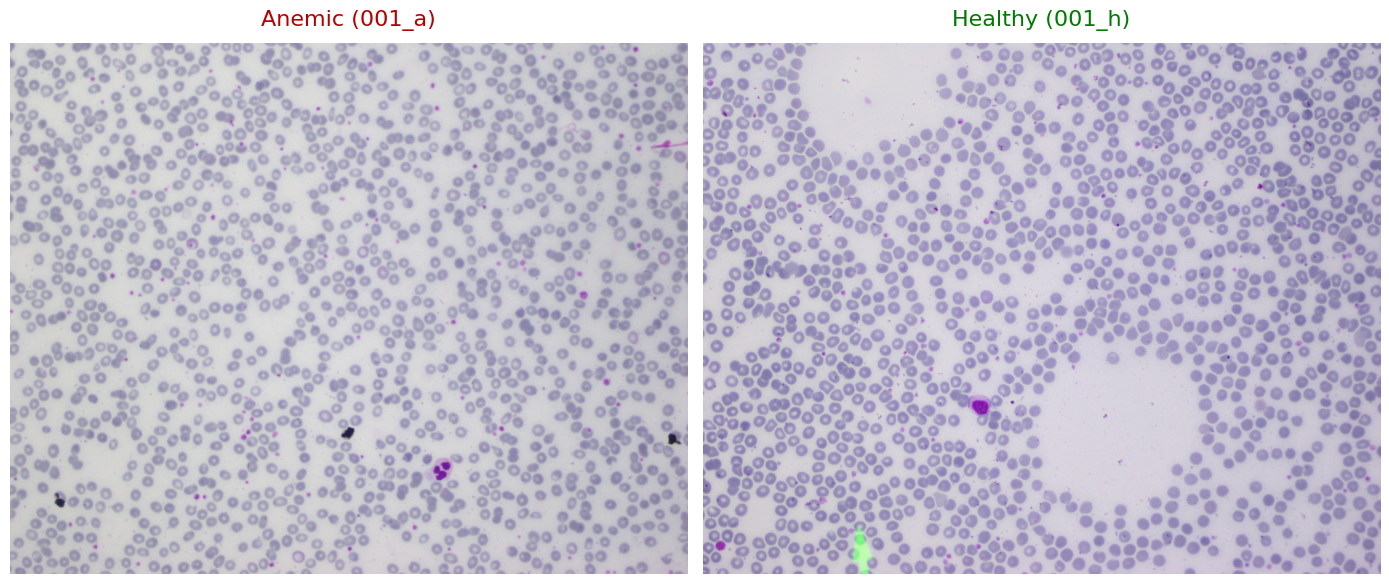

In [70]:
# --- AneRBC-I: Show one anemic and one healthy example ---
anemic_img_i  = base_i / 'Anemic_individuals'  / 'Original_images' / '001_a.png'
anemic_cbc_i  = base_i / 'Anemic_individuals'  / 'CBC_reports'     / '001_a.txt'
healthy_img_i = base_i / 'Healthy_individuals' / 'Original_images' / '001_h.png'
healthy_cbc_i = base_i / 'Healthy_individuals' / 'CBC_reports'     / '001_h.txt'

show_pair(anemic_img_i, anemic_cbc_i, 'Anemic (001_a)', healthy_img_i, healthy_cbc_i, 'Healthy (001_h)')

In [71]:
# --- AneRBC-I Dataset Summary ---
dataset_summary(base_i, 'AneRBC-I')

AneRBC-I — Total images: 1000


Class  No. of Images
0   Anemic            500
1  Healthy            500

  Anemic  resolution : 1224 × 960 px
  Healthy resolution : 1224 × 960 px


## AneRBC-II: Anemic vs Healthy Examples

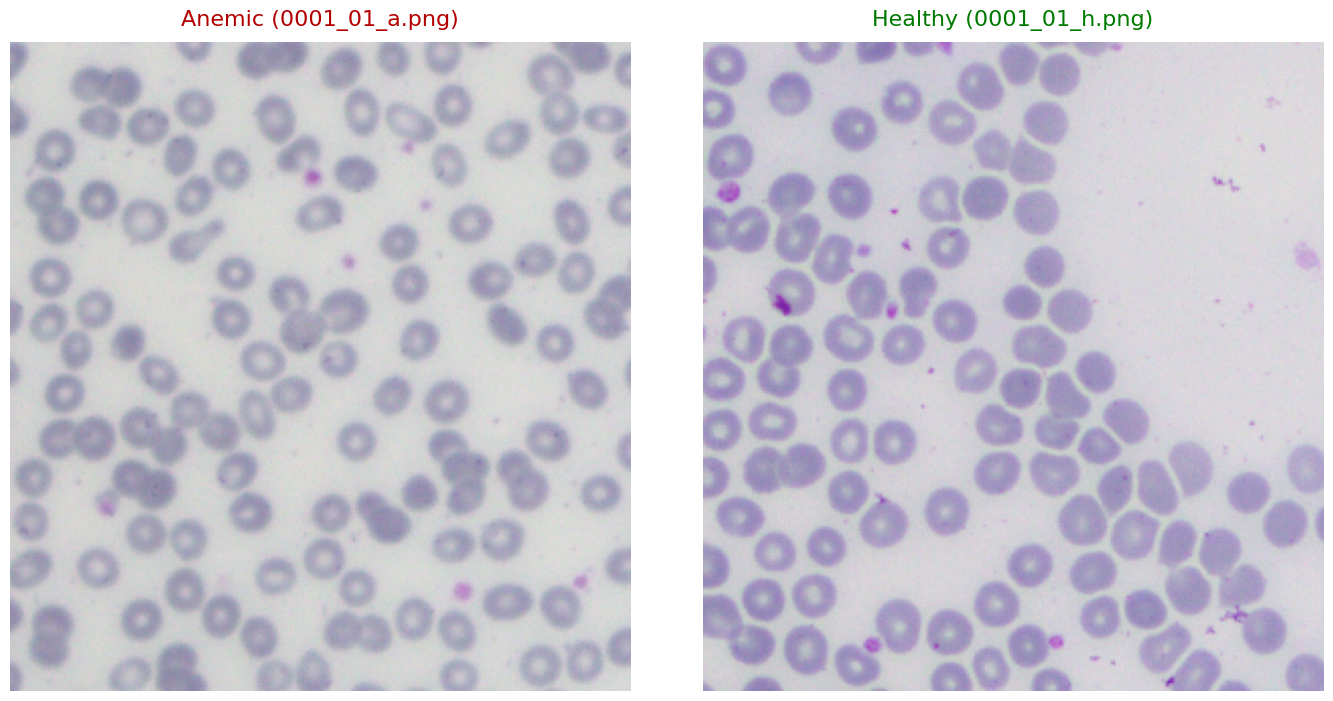

In [72]:
# --- AneRBC-II: Show one anemic and one healthy example ---
anemic_imgs_ii_list  = sorted((base_ii / 'Anemic_individuals'  / 'Original_images').glob('*.png'))
healthy_imgs_ii_list = sorted((base_ii / 'Healthy_individuals' / 'Original_images').glob('*.png'))
anemic_cbcs_ii_list  = sorted((base_ii / 'Anemic_individuals'  / 'CBC_reports').glob('*.txt'))
healthy_cbcs_ii_list = sorted((base_ii / 'Healthy_individuals' / 'CBC_reports').glob('*.txt'))

anemic_img_ii  = anemic_imgs_ii_list[0]
anemic_cbc_ii  = anemic_cbcs_ii_list[0]
healthy_img_ii = healthy_imgs_ii_list[0]
healthy_cbc_ii = healthy_cbcs_ii_list[0]

show_pair(anemic_img_ii, anemic_cbc_ii, f'Anemic ({anemic_img_ii.name})',
          healthy_img_ii, healthy_cbc_ii, f'Healthy ({healthy_img_ii.name})')

In [73]:
# --- AneRBC-II Dataset Summary ---
dataset_summary(base_ii, 'AneRBC-II')

AneRBC-II — Total images: 12000


Class  No. of Images
0   Anemic           6000
1  Healthy           6000

  Anemic  resolution : 306 × 320 px
  Healthy resolution : 306 × 320 px


## Dataset Comparison: AneRBC-I vs AneRBC-II

In [76]:
# --- Whole-dataset comparison ---
agg_cols = ['No_of_images','No_of_CBC_reports']

metrics_i  = dataset_level_metrics(base_i)
metrics_ii = dataset_level_metrics(base_ii)
df_whole = pd.DataFrame([metrics_i, metrics_ii], index=['AneRBC-I', 'AneRBC-II'])
print("Whole-dataset comparison:")
display(df_whole)

Whole-dataset comparison:


No_of_images  No_of_anemic_images  No_of_healthy_images  \
AneRBC-I           1000                  500                   500   
AneRBC-II         12000                 6000                  6000   

          Image_resolution  No_of_CBC_reports  
AneRBC-I          1224×960               1000  
AneRBC-II          306×320               1000

## AneRBC-I → AneRBC-II: Original vs 12 Sub-images

AneRBC-I contains one image per patient (e.g. `001_a.png`).  
AneRBC-II divides each of those images into 12 sub-images (e.g. `0001_01_a.png` … `0001_12_a.png`).  
The cell below visualizes this relationship for one anemic patient.

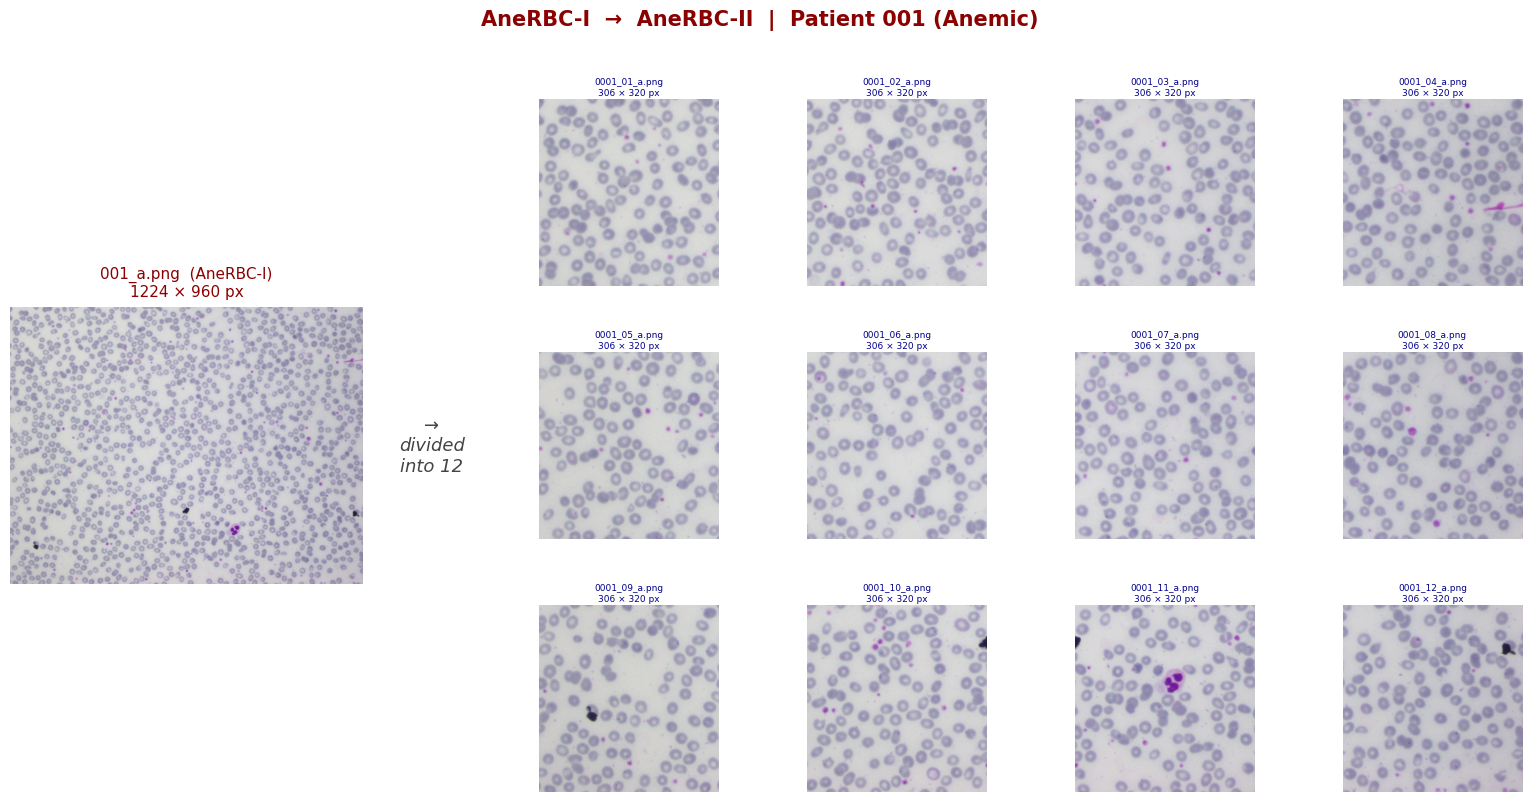

Original (AneRBC-I) : 001_a.png  (1224 × 960 px)
Sub-images (AneRBC-II): 12  → ['0001_01_a.png', '0001_02_a.png', '0001_03_a.png', '0001_04_a.png', '0001_05_a.png', '0001_06_a.png', '0001_07_a.png', '0001_08_a.png', '0001_09_a.png', '0001_10_a.png', '0001_11_a.png', '0001_12_a.png']


In [75]:
# --- AneRBC-I → AneRBC-II: Sub-image Relationship ---
anemic_orig   = base_i  / 'Anemic_individuals' / 'Original_images' / '001_a.png'
anemic_ii_dir = base_ii / 'Anemic_individuals' / 'Original_images'
sub_imgs      = sorted(anemic_ii_dir.glob('0001_*_a.png'))

# Layout: original | arrow label | 3×4 sub-image grid
fig    = plt.figure(figsize=(20, 9))
fig.suptitle('AneRBC-I  →  AneRBC-II  |  Patient 001 (Anemic)',
             fontsize=15, fontweight='bold', color='#8b0000')
outer  = gridspec.GridSpec(1, 3, figure=fig, wspace=0.05, width_ratios=[4, 1, 12])

# Left: original
ax_orig = fig.add_subplot(outer[0])
with Image.open(anemic_orig) as im:
    orig_w, orig_h = im.size
    ax_orig.imshow(im.convert('RGB'))
ax_orig.axis('off')
ax_orig.set_title(f'001_a.png  (AneRBC-I)\n{orig_w} × {orig_h} px', fontsize=11, color='#8b0000', pad=8)

# Middle: arrow
ax_mid = fig.add_subplot(outer[1])
ax_mid.axis('off')
ax_mid.text(0.5, 0.5, '→\ndivided\ninto 12', ha='center', va='center',
            transform=ax_mid.transAxes, fontsize=13, color='#444', style='italic')

# Right: 3×4 grid of sub-images
inner = gridspec.GridSpecFromSubplotSpec(3, 4, subplot_spec=outer[2], hspace=0.35, wspace=0.05)
for idx in range(12):
    row, col = divmod(idx, 4)
    ax = fig.add_subplot(inner[row, col])
    if idx < len(sub_imgs):
        with Image.open(sub_imgs[idx]) as im:
            w, h = im.size
            ax.imshow(im.convert('RGB'))
        ax.set_title(f'{sub_imgs[idx].name}\n{w} × {h} px', fontsize=6.5, color='#00008b', pad=3)
    else:
        ax.text(0.5, 0.5, 'N/A', ha='center', va='center', transform=ax.transAxes, color='gray')
    ax.axis('off')

plt.show()
print(f"Original (AneRBC-I) : {anemic_orig.name}  ({orig_w} × {orig_h} px)")
print(f"Sub-images (AneRBC-II): {len(sub_imgs)}  → {[p.name for p in sub_imgs]}")